<a href="https://colab.research.google.com/github/orenshor/deepLearning_ass1/blob/master/ass_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [81]:
import numpy as np
from keras import Sequential
from keras.callbacks import LearningRateScheduler, ModelCheckpoint, ReduceLROnPlateau, Callback
from keras.preprocessing.image import ImageDataGenerator
from keras.datasets import cifar100
from keras.layers import Dense, Conv2D, Flatten, Input, AvgPool2D,MaxPool2D,Dropout, BatchNormalization
from keras.optimizers import SGD
from keras.regularizers import l2
from keras.utils import to_categorical
from matplotlib import pyplot as plt
from keras.models import Model, Sequential
from sklearn.metrics import confusion_matrix,accuracy_score,log_loss
import seaborn as sns

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [0]:
# Model configuration
batch_size = 50
img_width, img_height, img_num_channels = 32, 32, 3
num_classes = 100
num_epochs = 100
optimizer = Adam()
validation_split = 0.2
verbosity = 1
L2_DECAY_RATE = 0.0005
INIT_DROPOUT_RATE = 0.5

CIFAR100_LABELS_LIST = [
    'apple', 'aquarium_fish', 'baby', 'bear', 'beaver', 'bed', 'bee', 'beetle', 
    'bicycle', 'bottle', 'bowl', 'boy', 'bridge', 'bus', 'butterfly', 'camel', 
    'can', 'castle', 'caterpillar', 'cattle', 'chair', 'chimpanzee', 'clock', 
    'cloud', 'cockroach', 'couch', 'crab', 'crocodile', 'cup', 'dinosaur', 
    'dolphin', 'elephant', 'flatfish', 'forest', 'fox', 'girl', 'hamster', 
    'house', 'kangaroo', 'keyboard', 'lamp', 'lawn_mower', 'leopard', 'lion',
    'lizard', 'lobster', 'man', 'maple_tree', 'motorcycle', 'mountain', 'mouse',
    'mushroom', 'oak_tree', 'orange', 'orchid', 'otter', 'palm_tree', 'pear',
    'pickup_truck', 'pine_tree', 'plain', 'plate', 'poppy', 'porcupine',
    'possum', 'rabbit', 'raccoon', 'ray', 'road', 'rocket', 'rose',
    'sea', 'seal', 'shark', 'shrew', 'skunk', 'skyscraper', 'snail', 'snake',
    'spider', 'squirrel', 'streetcar', 'sunflower', 'sweet_pepper', 'table',
    'tank', 'telephone', 'television', 'tiger', 'tractor', 'train', 'trout',
    'tulip', 'turtle', 'wardrobe', 'whale', 'willow_tree', 'wolf', 'woman',
    'worm'
]

In [0]:
(X_train, y_train), (X_test, y_test) = cifar100.load_data(label_mode='fine')
input_shape = (img_width, img_height, img_num_channels)
# Parse numbers as floats
input_train = input_train.astype('float32')
input_test = input_test.astype('float32')

# Normalize data
input_train = input_train / 255
input_test = input_test / 255

In [59]:
#lets look at the data:
print('X_train shape is: {} \n\
y_train shape is: {}'.format(X_train.shape,y_train.shape))
print()
print('X_test shape is: {} \n\
y_test shape is: {}'.format(X_test.shape,y_test.shape))

X_train shape is: (50000, 32, 32, 3) 
y_train shape is: (50000, 1)

X_test shape is: (10000, 32, 32, 3) 
y_test shape is: (10000, 1)


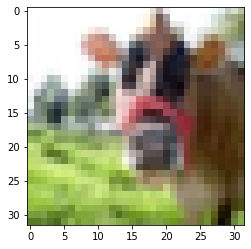

In [60]:
# plt.imshow(X_train[0])
plt.imshow(X_train[0],cmap='binary')

In [0]:
def plot_multiple_imgs(X,y,nrow=2,ncol=2,figsize=(13,7),preds=None,skip=0):
    fig = plt.figure(figsize=(32, 32))
    counter = 0
    showen_categories = []
    for i in range(10000):
      if(preds is None):
        if(CIFAR100_LABELS_LIST[y[i][0]] not in showen_categories ):
            showen_categories.append(CIFAR100_LABELS_LIST[y[i][0]])
            sub = fig.add_subplot(10, 10, counter+1)
            sub.imshow(X[i], cmap='binary')
            sub.text(0.85,0.1,CIFAR100_LABELS_LIST[y[i][0]], color='red', weight='bold',fontsize=20)
            counter = counter + 1
      else:
        if (preds[i]!=y[i]):
          sub = fig.add_subplot(10, 10, counter+1)
          sub.imshow(X[i] ,cmap='binary')
          sub.text(0.85,0,"predict: " + CIFAR100_LABELS_LIST[preds[i]], color='red', weight='bold',fontsize=20)
          sub.text(0.85,35,"real: " + CIFAR100_LABELS_LIST[y[i][0]], color='green', weight='bold',fontsize=20)
          counter = counter + 1
      if(counter==100):
          break


# plot_multiple_imgs(X_train,y_train,10,10,(12,8))

In [0]:
# Create the model
def create_model_1():
  model = Sequential()
  model.add(Conv2D(16,3,activation='relu', padding='same', input_shape=(32,32,3)))
  model.add(Dropout(0.2))
  model.add(MaxPool2D(pool_size=(2, 2)))
  model.add(BatchNormalization())

  model.add(Conv2D(32,3,activation='relu', padding='same',))
  model.add(Dropout(0.2))
  model.add(MaxPool2D(pool_size=(2, 2)))
  model.add(BatchNormalization())

  model.add(Conv2D(128,3,activation='relu', padding='same',))
  model.add(Dropout(0.2))
  model.add(MaxPool2D(pool_size=(2, 2)))
  model.add(BatchNormalization())

  model.add(Conv2D(256,3,activation='relu', padding='same',))
  model.add(Dropout(0.2))
  model.add(MaxPool2D(pool_size=(2, 2)))
  model.add(BatchNormalization())

  model.add(Flatten())
  model.add(Dense(num_classes, activation='softmax'))

  model.summary()
  return model

In [0]:
def confusion_matrix_predict(model):
    preds = model.predict(input_test)
    predicts = np.argmax(preds, axis=1) #return the predicted category in each sample in test set
    print(confusion_matrix(target_test,predicts))
    print('model accuracy on test set is: {}%'.format(accuracy_score(target_test,predicts)*100))
    # sns.heatmap(confusion_matrix(target_test,predicts),cmap='Greens',annot=False, fmt='d')
    plt.xlabel('Prediction')
    plt.ylabel('True label')
    plt.title('Classification results on test set')
    print()

Model: "sequential_20"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_76 (Conv2D)           (None, 32, 32, 16)        448       
_________________________________________________________________
dropout_69 (Dropout)         (None, 32, 32, 16)        0         
_________________________________________________________________
max_pooling2d_70 (MaxPooling (None, 16, 16, 16)        0         
_________________________________________________________________
batch_normalization_70 (Batc (None, 16, 16, 16)        64        
_________________________________________________________________
conv2d_77 (Conv2D)           (None, 16, 16, 32)        4640      
_________________________________________________________________
dropout_70 (Dropout)         (None, 16, 16, 32)        0         
_________________________________________________________________
max_pooling2d_71 (MaxPooling (None, 8, 8, 32)        

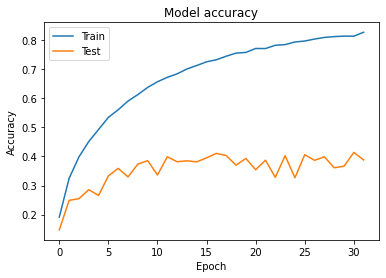

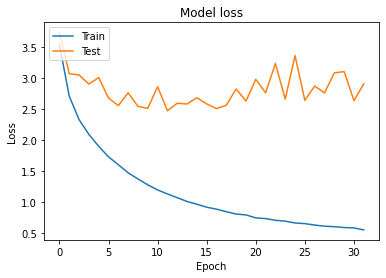

[[58  0  1 ...  0  0  0]
 [ 1 35  0 ...  1  0  1]
 [ 0  0 24 ...  3  1  0]
 ...
 [ 0  0  1 ... 49  0  0]
 [ 0  0 11 ...  0  9  3]
 [ 0  0  0 ...  2  0 54]]
model accuracy on test set is: 40.239999999999995%



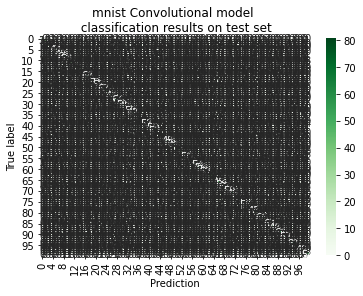

In [86]:
callbacks_model = [EarlyStopping('val_loss', patience=20),
             ModelCheckpoint('cifar100Model_100e_keras.h5', save_best_only=True)]
# # Compile the model
model_1 = create_model_1()
# model_1.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])

# # Fit data to model
# history = model_1.fit(X_train,
#                       to_categorical(y_train),
#                       callbacks=callbacks_model,
#                       validation_split=0.2,
#                       shuffle=True,
#                       epochs=100)

model_1.load_weights('cifar100Model_100e_keras.h5')

# Visualize history
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()


preds = model_1.predict(X_test)
predicts = np.argmax(preds, axis=1) 
print(confusion_matrix(y_test,predicts))
print('model accuracy on test set is: {}%'.format(accuracy_score(y_test,predicts)*100))


# # Plot history: Loss
# plt.plot(history.history['val_loss'])
# plt.title('Validation loss history')
# plt.ylabel('Loss value')
# plt.xlabel('No. epoch')
# plt.show()

# # Plot history: Accuracy
# plt.plot(history.history['val_accuracy'])
# plt.title('Validation accuracy history')
# plt.ylabel('Accuracy value (%)')
# plt.xlabel('No. epoch')
# plt.show()

# plot_multiple_imgs(X_test,y_test,10,10,(12,12),predicts,skip=200)
sns.heatmap(confusion_matrix(y_test,predicts),cmap='Greens',annot=True, fmt='d')
plt.xlabel('Prediction')
plt.ylabel('True label')
plt.title('mnist Convolutional model \n classification results on test set')
print()